# Fuzzy K-Means
- Author: [Ammar Sherif](https://github.com/ammarSherif)
- Email: ammarsherif90 [at] gmail [dot] com
- Github: [Fuzzy-K-Means](https://github.com/ammarSherif/Fuzzy-K-Means)

<div class="alert alert-block alert-info">
<b>Acknowledgement:</b> the below comparison code is highly adapted from <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html" target="_blank">sklearn's code</a>, but with customizing to compare between our Fuzzy KMeans and normal one.
</div>

In [1]:
# ==============================================================================
# Author: Ammar Sherif <ammarsherif90 [at] gmail [dot] com >
# License: MIT
# ==============================================================================

# ==============================================================================
# Import some utilities to help us with plotting and testing the algorithm
# ==============================================================================
import time

import numpy as np
import matplotlib.pyplot as plt
# ==============================================================================
# Importing the needed datasets and kmeans  from sklearn to test  our fuzzy ver-
# sion on.
# ==============================================================================
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
# ==============================================================================
# Import the class
# ==============================================================================
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from fuzzy_kmeans.fuzzy_kmeans import FuzzyKMeans

In [2]:
# ==============================================================================
# Initialize the seed for reproducibility
# ==============================================================================
np.random.seed(0)

## Datasets

We are generating 6 different datasets:
1. two circles
2. two moons
3. blobs with varied variances
4. anisotropicly distributed blobs
5. normal blobs
6. random

In [3]:
# ==============================================================================
# Create some datasets as in sklearn's comparison
# ==============================================================================
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples,factor=0.5,noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
random_data = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied_var = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ==============================================================================
# Putting them together (Dataset name, dataset, n_clusters)
# ==============================================================================
datasets_lst = [("Two Circles",noisy_circles,2),
                ("Two Moons",noisy_moons,2),
                ("Varied Variance",varied_var,3),
                ("Anisotropicly Distributed",aniso,3),
                ("Normal Blobs",blobs,3),
                ("Random Data",random_data,3)]

### Plotting the datasets

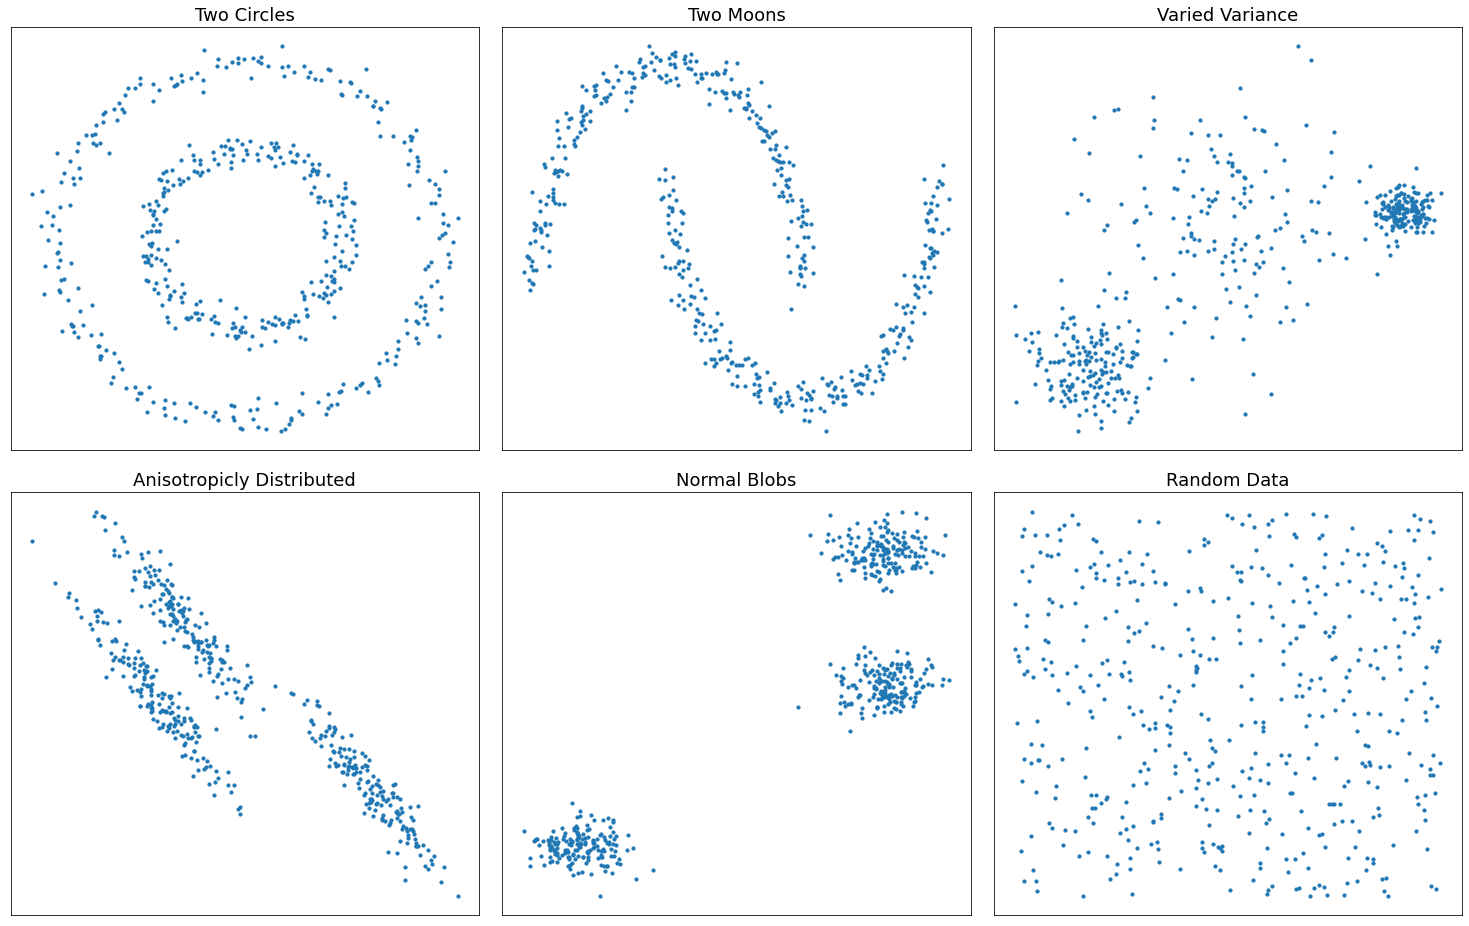

In [4]:
# ==============================================================================
# Plotting the 6 datasets
# ==============================================================================
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.1
)
for i,(dataset_name,dataset,_) in enumerate(datasets_lst):
    plt.subplot(2, len(datasets_lst)//2, i+1)
    plt.title(dataset_name, size=18)
    plt.scatter(dataset[0][:, 0], dataset[0][:, 1], s=10)
    plt.xticks(())
    plt.yticks(())
plt.show()

## Comparing Algorithms

In this section, we will be comparing between Fuzzy K-Means vs normal one while changing the value of `m`,**fuzziness index**. Also, within the plot, *the opacity will vary indicating the confidence,* so less confident results have less opacity. The algorithms we will be comparing:
1. K-Means
2. Fuzzy K-Means with `m = 1.2`
3. Fuzzy K-Means with `m = 2`
4. Fuzzy K-Means with `m = 4`
5. Fuzzy K-Means with `m = 6`
6. Fuzzy K-Means with `m = 8`
7. Fuzzy K-Means with `m = 10`
8. Fuzzy K-Means with `m = 12`
9. Fuzzy K-Means with `m = 14`
10. Fuzzy K-Means with `m = 20`

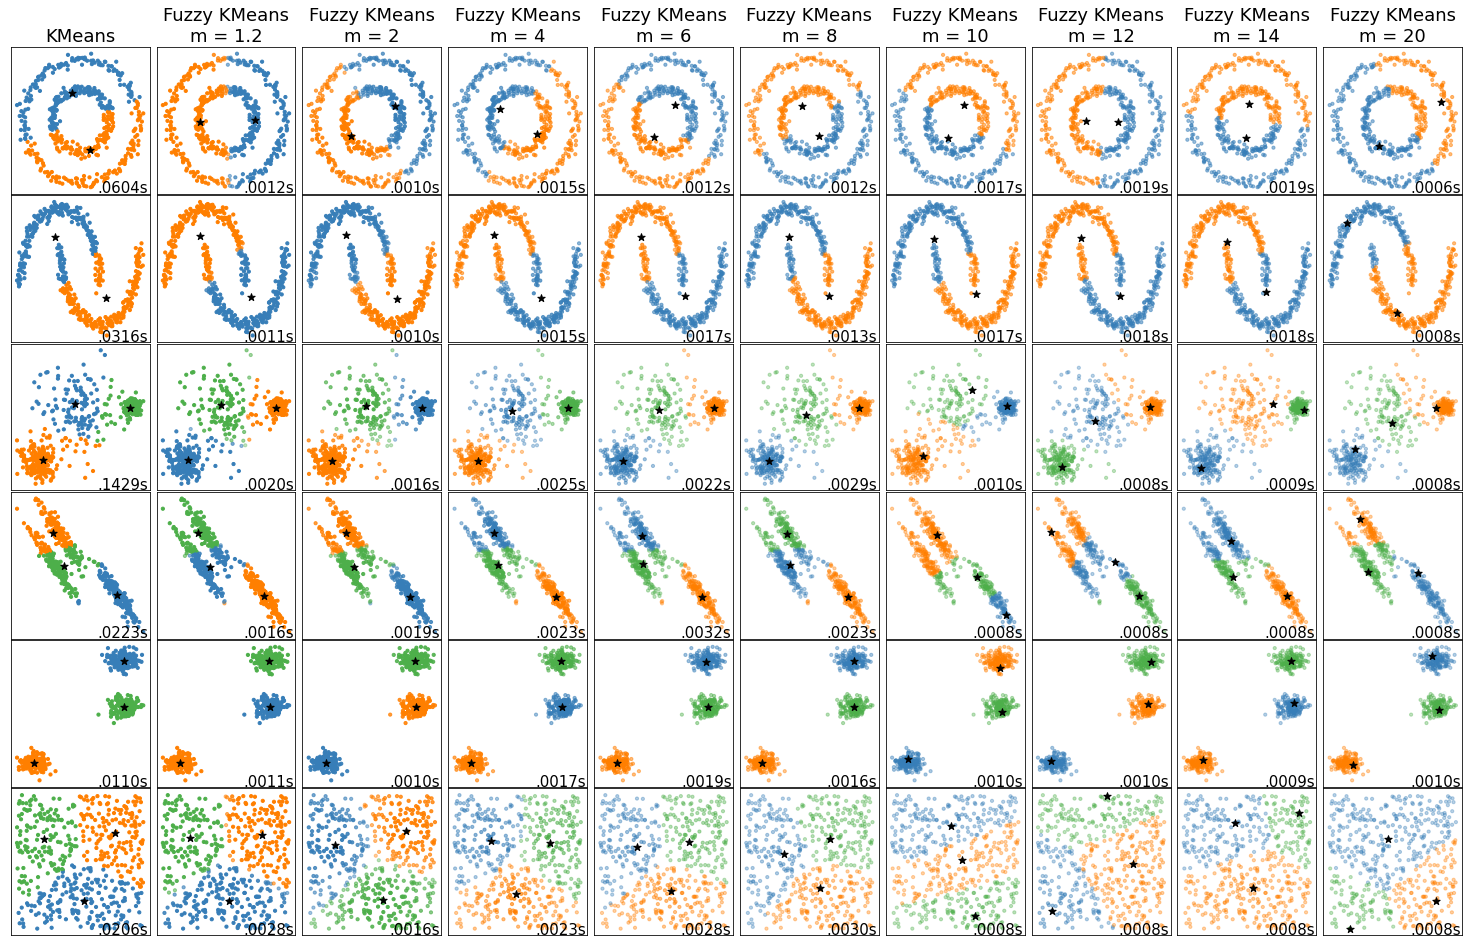

In [5]:
# ==============================================================================
# Configure the plotting area
# ==============================================================================
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)


# ==============================================================================
# Loop over all the datasets
# ==============================================================================
for i_dataset, (dataset_name, dataset, n_clusters) in enumerate(datasets_lst):
    # --------------------------------------------------------------------------
    # Extract the dataset
    # --------------------------------------------------------------------------
    X, y = dataset
    # --------------------------------------------------------------------------
    # normalize dataset for easier parameter selection
    # --------------------------------------------------------------------------
    X = StandardScaler().fit_transform(X)
    
    # --------------------------------------------------------------------------
    # Create clustering estimator objects based on our algorithms
    # --------------------------------------------------------------------------
    kmeans = KMeans(n_clusters= n_clusters)
    fuzzy_m12 = FuzzyKMeans(m = 1.2, n_clusters= n_clusters)
    
    clustering_algorithms = [("KMeans",kmeans),
                            ("Fuzzy KMeans\nm = 1.2",fuzzy_m12)]
    # --------------------------------------------------------------------------
    # Create the remaining fuzzy clustering estimators with the assigned m
    # --------------------------------------------------------------------------
    for m_val in range(2,21,2):
        # ----------------------------------------------------------------------
        # We do not create values with m = 16 or 18
        # ----------------------------------------------------------------------
        if m_val in [16,18]:
            continue
        
        alg_name = "Fuzzy KMeans\nm = {}".format(m_val)
        alg = FuzzyKMeans(m = m_val, n_clusters= n_clusters)
        clustering_algorithms.append((alg_name,alg))
    
    # --------------------------------------------------------------------------
    # Now loop over all the algorithms to fit and plot
    # --------------------------------------------------------------------------
    for i_alg, (alg_name, algorithm) in enumerate(clustering_algorithms):
        # ----------------------------------------------------------------------
        # Compute the plot number
        # ----------------------------------------------------------------------
        plot_num = i_dataset * len(clustering_algorithms) + i_alg + 1
        # ----------------------------------------------------------------------
        # Compute the starting time to know the excution time later on
        # ----------------------------------------------------------------------
        t0 = time.time()
        
        # ----------------------------------------------------------------------
        # Fit the algorithm
        # ----------------------------------------------------------------------
        algorithm.fit(X)
        
        t1 = time.time()
        
        # ----------------------------------------------------------------------
        # Configure the opacity within the Fuzzy version to be the  value of max
        # membership and 1 within the normal KMeans
        # ----------------------------------------------------------------------
        if hasattr(algorithm, "fmm_"):
            opacity = algorithm.fmm_.max(axis=1)
        else:
            opacity = np.ones(algorithm.labels_.shape)
        
        # ----------------------------------------------------------------------
        # Configure the plot
        # ----------------------------------------------------------------------
        plt.subplot(len(datasets_lst), len(clustering_algorithms), plot_num)
        
        # ----------------------------------------------------------------------
        # Show the algorithm names if it is the first row
        # ----------------------------------------------------------------------
        if i_dataset == 0:
            plt.title(alg_name, size=18)
            
        # ----------------------------------------------------------------------
        # Configure the colors
        # ----------------------------------------------------------------------
        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(algorithm.labels_) + 1),
                )
            )
        )
        # ----------------------------------------------------------------------
        # Now, plot the datasets with clustering and the centroids
        # ----------------------------------------------------------------------        
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[algorithm.labels_],
                    alpha = opacity)
        centroids = algorithm.cluster_centers_
        scatter_centroids = plt.scatter(centroids[:, 0], 
                                        centroids[:, 1], s=60, 
                                        color="#000000",
                                        marker = '*')
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.4fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )

# ==============================================================================
# Finally, show the plot
# ==============================================================================
plt.show()